# Novelty Detection - PCD Constructive - NNet Approach

## Novelty Detection

Change the classifier detection threshold to enable novelty detection. If the classifier output is below the threshold of each neuron, that is, the classifier does not recognize the input as any of the known classes, than the input is considered to be a new class. As it is expected that the classifier misses the target, some cumulative approach might avoid the classifier to indicate a novelty 'at first glance'.

# Results

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas
from sklearn.externals import joblib
import PyNN.NeuralNet as PyNNet
import PyNN.TrnInfo as PyTrnInfo
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Standard styles for each class
dashes = [[],[10,10],[10,4,2,4],[10,5,100,5]] 
colors = ['b','r','g','y']

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.borderpad'] = 0.3
mpl.rcParams['legend.numpoints'] = 1


classes = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
noveltyclasses = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
sonarhome = os.getenv('SONARHOME')
fname = sonarhome + '/data/lofar_data_1024fft_3dec_fromMat.jbl'
pcddir = sonarhome + '/results/classification/novelty/PCD_Constructive/'
nPts = 400

/home/xavier/.virtualenvs/sonar/local/lib/python2.7/site-packages/matplotlib/__init__.py:1039: UserWarning: Bad val "pyside" on line #38
	"backend      : pyside
"
	in file "/home/xavier/.virtualenvs/sonar/local/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc"
	Key backend: Unrecognized backend string "pyside": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


In [2]:
# Load and divide data
globaldata = joblib.load(fname)
cls_data = {}
for cls in classes:
    cls_data[cls] = np.concatenate([y['Signal'][:nPts] for y in globaldata[cls].values()], axis=1).transpose()
def novelty_data(clsnov, data):
    use_classes = np.sort(np.setdiff1d(data.keys(), clsnov))
    Xnov = np.concatenate([data[cls] for cls in clsnov], axis=0)
    X = np.concatenate([data[cls] for cls in use_classes], axis=0)
    nClass = len(use_classes)
    T = None
    for icls, cls in enumerate(use_classes):
        tot = data[cls].shape[0]
        if nClass == 2:
            aux = -np.ones(1)
            aux[0] = 1 if icls > 0 else -1
        else:
            aux = -np.ones(nClass)
            aux[icls] = 1
        T = np.tile(aux,(tot,1)) if T is None else np.concatenate((T, np.tile(aux,(tot,1))))
    return X, T, Xnov

## PCD Network

In [3]:
nov_pcdnet = {}
npcd = 18
IPCD = {
    'ClasseA': 2,
    'ClasseB': 4,
    'ClasseC': 0,
    'ClasseD': 2
}
for cls in noveltyclasses:
    filepcd = pcddir + '/pcdcons_cv_' + cls + '_fromMat_1024nfft.jbl'
    nov_pcdnet[cls] = joblib.load(filepcd)
del filepcd

## Simulation

In [5]:
Y = {}
data = {}
for novcls in noveltyclasses:
    Y[novcls] = {}
    data[novcls] = {}
    NCV = nov_pcdnet[novcls]['cvPar']['CVNSel']
    # Over CV
    X, T, Xnov = novelty_data([novcls], cls_data)
    data[novcls]['Input'] = X
    data[novcls]['Target'] = T 
    data[novcls]['InNov'] = Xnov
    data[novcls]['Labels'] = nov_pcdnet[novcls]['Classes']         
    for icv in range(NCV):
        Y[novcls][icv] = {}
        nnet = nov_pcdnet[novcls]['PCDModel'].results[icv].PCDNets[npcd]
        Y[novcls][icv]['Output'] = nnet.feedforward(data[novcls]['Input'])
        Y[novcls][icv]['OutNov'] = nnet.feedforward(data[novcls]['InNov'])
        #Y[novcls][icv]['ITest'] = nnet.trn_info.itrn
        Y[novcls][icv]['ITest'] = range(T.shape[0])

### Novelty Detection Over Cross Validation

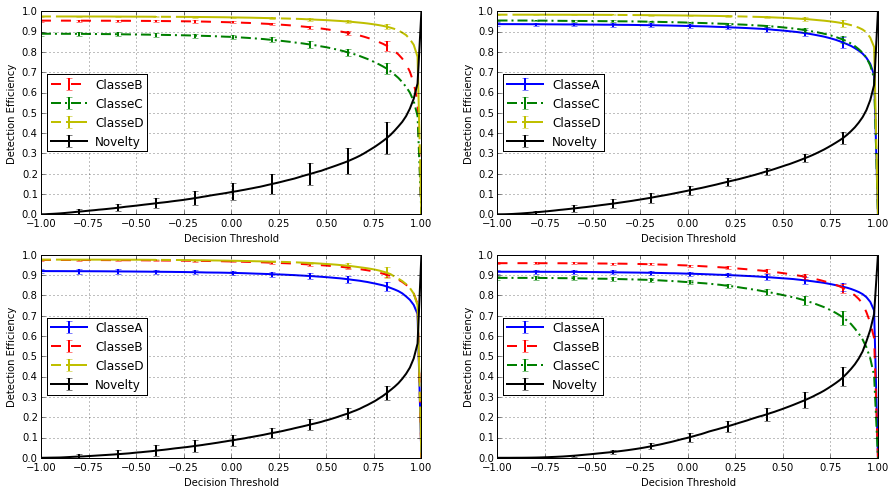

In [6]:
plt.figure(figsize=(15,8), facecolor='w')
thrs = np.linspace(-1, 1, 100)
# Loop over novelties
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    NCV = nov_pcdnet[novcls]['PCDModel'].CVNSel
    T = data[novcls]['Target']
    # PLot Known classes
    effnov = np.zeros((NCV, len(thrs)))  # novely efficiency
    for iout in range(len(data[novcls]['Labels'])):
        # Loop over cross-validation
        tpr = np.zeros((NCV, len(thrs)))  # true positive rate
        for icv in range(NCV):
            Yout = Y[novcls][icv]['Output']
            itst = Y[novcls][icv]['ITest']
            # Loop over thresholds
            for ithr, thr in enumerate(thrs):
                # True Positive: greater than the threshold and the other neurons.
                TP = np.sum((Yout[itst, iout]>=thr) & (np.argmax(Yout[itst], axis=1) == iout) & (T[itst, iout] == 1))
                tpr[icv,ithr] = TP / float(np.sum((T[itst, iout] == 1)))
        # Plot
        icls = np.nonzero(classes == data[novcls]['Labels'][iout])[0]
        plt.errorbar(thrs, np.mean(tpr, axis=0), np.std(tpr, axis=0), dashes=dashes[icls],color=colors[icls],
                     errorevery=10, label=data[novcls]['Labels'][iout])
    # Plot Novelty
    for icv in range(NCV):
        Ynov = Y[novcls][icv]['OutNov']
        effnov[icv] = np.array([np.sum(np.max(Ynov, axis=1) < thr) for thr in thrs], 'f')/Ynov.shape[0]
    plt.errorbar(thrs, np.mean(effnov, axis=0), np.std(effnov, axis=0),fmt='k-', errorevery=10, label='Novelty')
    # Plot aspects
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(-1,1.25,0.25))
    plt.xlim([-1,1])
    plt.ylim([0,1])
    plt.grid()
    plt.xlabel('Decision Threshold')
    plt.ylabel('Detection Efficiency')
    plt.legend(loc='center left').get_frame().set_facecolor('1')

#### Novelty Detection for Best Net

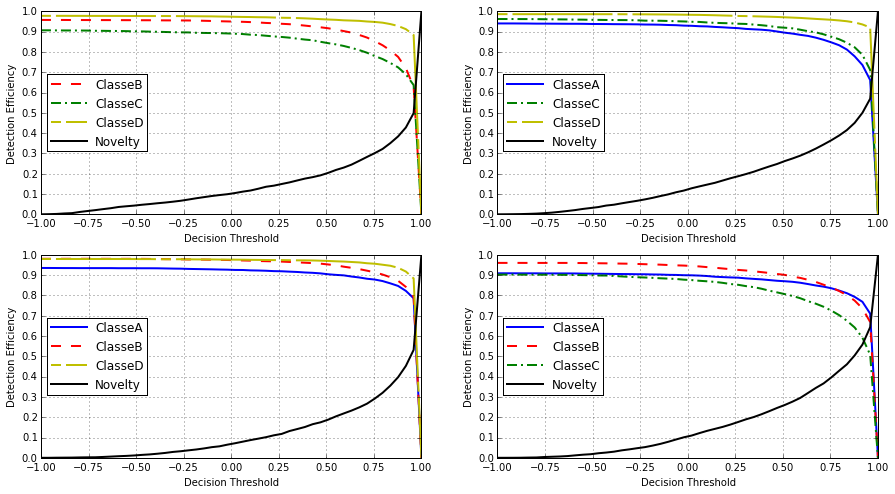

In [7]:
plt.figure(figsize=(15,8), facecolor='w')
thrs = np.linspace(-1, 1, 50)
# Loop over novelties
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    T = data[novcls]['Target']
    # PLot Known classes
    for iout in range(len(data[novcls]['Labels'])):
        tpr = np.zeros(len(thrs))  # true positive rate
        Yout = Y[novcls][IPCD[novcls]]['Output']
        itst = Y[novcls][IPCD[novcls]]['ITest']
        # Loop over thresholds
        for ithr, thr in enumerate(thrs):
            # True Positive: greater than the threshold and the other neurons.
            TP = np.sum((Yout[itst, iout]>=thr) & (np.argmax(Yout[itst], axis=1) == iout) & (T[itst, iout] == 1))
            tpr[ithr] = TP / float(np.sum((T[itst, iout] == 1)))
        # Plot
        icls = np.nonzero(classes == data[novcls]['Labels'][iout])[0]
        plt.plot(thrs, tpr,markevery=10, dashes=dashes[icls],color=colors[icls],
                 label=data[novcls]['Labels'][iout])
    # Plot Novelty
    Ynov = Y[novcls][IPCD[novcls]]['OutNov']
    effnov = np.array([np.sum(np.max(Ynov, axis=1) < thr) for thr in thrs], 'f')/Ynov.shape[0]
    plt.plot(thrs,effnov,'k-',markevery=10, label='Novelty')
    # Plot aspects
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(-1,1.25,0.25))
    plt.xlim([-1,1])
    plt.ylim([0,1])
    plt.grid()
    plt.xlabel('Decision Threshold')
    plt.ylabel('Detection Efficiency')
    plt.legend(loc='center left').get_frame().set_facecolor('1')

## Time Simulation

In [8]:
Y = {}
nnet_thr = 0.5
# Loop over classifiers
for novcls in noveltyclasses:
    Y[novcls] = {}
    Y[novcls]['Classes'] = nov_pcdnet[novcls]['Classes']
    Y[novcls]['Simul'] = {}
    Y[novcls]['Timew'] = {}
    Y[novcls]['KnownDetec'] = {}
    Y[novcls]['KnownAsNov'] = {}
    Y[novcls]['NovelAsKnown'] = {}
    Y[novcls]['NovelDet'] = {} # novelty detection
    nnet = nov_pcdnet[novcls]['PCDModel'].results[IPCD[novcls]].PCDNets[npcd]
    # Loop over data from each class
    for icls, cls in enumerate(classes):
        Y[novcls]['Simul'][cls] = {} # per run
        Y[novcls]['Timew'][cls] = {}
        # Each class run
        for run in globaldata[cls].keys():
            X = globaldata[cls][run]['Signal'][:nPts].transpose()
            Y[novcls]['Simul'][cls][run] = nnet.feedforward(X)
            nfft = float(globaldata[cls][run]['NFFT'])
            Fs   = float(globaldata[cls][run]['Fs'])
            Y[novcls]['Timew'][cls][run] = np.arange(1,X.shape[0]+1) * nfft/Fs
    # CALCULATE EFFIENCIES
    # Known-classes
    for iout, cls in enumerate(Y[novcls]['Classes']):
        Y[novcls]['KnownDetec'][cls] = {} # detection of each time window
        Y[novcls]['KnownAsNov'][cls] = {} # detection of known classes as novelty
        for run in globaldata[cls].keys():
            output = Y[novcls]['Simul'][cls][run]
            # Detecting known classes as known classes
            tpr = np.array((output[:, iout] > nnet_thr) & (np.argmax(output, axis=1) == iout), 'f')
            Y[novcls]['KnownDetec'][cls][run] = tpr
            # Detecting known classes as novelties
            tpr = np.array((np.max(output, axis=1) < nnet_thr),'f')
            Y[novcls]['KnownAsNov'][cls][run] = tpr
    # Novelty class
    for cls in Y[novcls]['Classes']: Y[novcls]['NovelAsKnown'][cls] = {}
    for run in globaldata[novcls].keys():
        # Novelty efficiency
        output = Y[novcls]['Simul'][novcls][run]
        tpr = np.array((np.max(output, axis=1) < nnet_thr),'f')
        Y[novcls]['NovelDet'][run] = tpr
        # Novelty detected as a known class
        for iout, cls in enumerate(Y[novcls]['Classes']):
            tpr = np.array((output[:, iout] > nnet_thr) & (np.argmax(output, axis=1) == iout), 'f')
            Y[novcls]['NovelAsKnown'][cls][run] = tpr

### Known-classes Efficiency

#### Cumulative efficiency to detect a known class

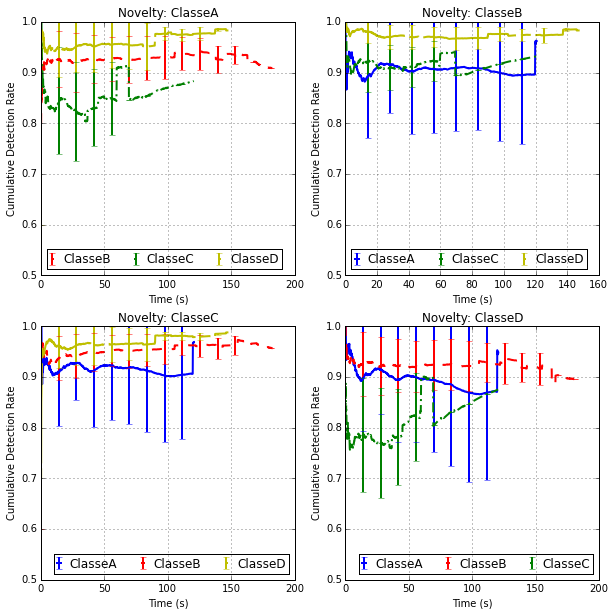

In [9]:
plt.figure(figsize=(10,10), facecolor='w')
for ifig, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2, ifig+1)
    for cls, rundata in Y[novcls]['KnownDetec'].items():
        maxT = np.max([globaldata[cls][irun]['Signal'].shape[1] for irun in globaldata[cls].keys()])
        eff_y = np.zeros((len(globaldata[cls]), maxT)) * np.nan # runs x time total
        eff_x = np.zeros((len(globaldata[cls]), maxT)) * np.nan
        for irun, run in enumerate(rundata.keys()):
            tpr = rundata[run]
            eff_y[irun, :len(tpr)] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
            eff_x[irun, :len(tpr)] = Y[novcls]['Timew'][cls][run]
        # Plot
        icls = np.nonzero(classes == cls)[0][0]
        avgeff = np.nanmean(eff_y, axis=0)
        stdeff = np.nanstd(eff_y, axis=0)
        timew = np.nanmean(eff_x, axis=0)
        plt.errorbar(timew,  avgeff, stdeff,errorevery=100,
                     dashes=dashes[icls],color=colors[icls],label=cls)
    # Plot labels
    plt.ylim([0.5,1])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Detection Rate')
    plt.title('Novelty: ' + novcls)
    plt.legend(loc='best', ncol=3, handlelength=0.3,borderpad=0.3)
        

#### Cumulative efficiency to detect a known class (20s windows)

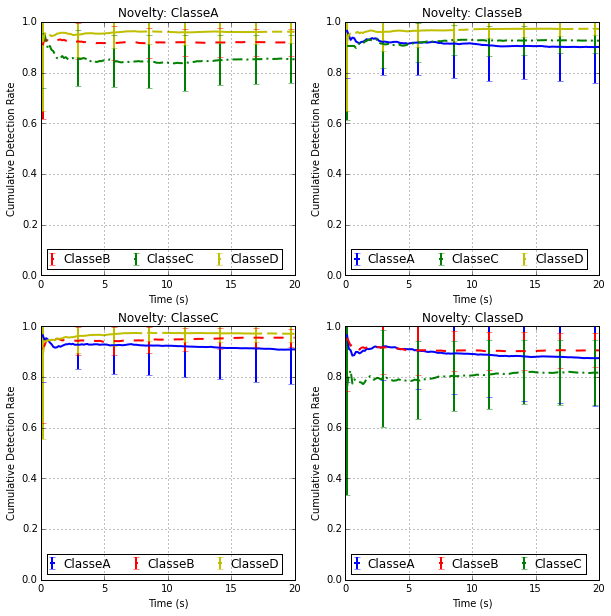

In [81]:
tot_t = 20 # seconds
plt.figure(figsize=(10,10), facecolor='w')
for ifig, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2, ifig+1)
    for cls, rundata in Y[novcls]['KnownDetec'].items():
        # Sample rate is always the same
        tot_samples = int(tot_t / Y[novcls]['Timew'][cls][0][0])
        N = np.sum([int(Y[novcls]['Timew'][cls][run][-1] / tot_t) for run in rundata.keys()])
        window_eff = np.zeros((N, tot_samples))
        timew = np.linspace(Y[novcls]['Timew'][cls][0][0], tot_t, tot_samples)  
        win_run_idx = 0
        n = 0
        for run in rundata.keys():
            tot_n = int(Y[novcls]['Timew'][cls][run][-1] / tot_t)
            n = n + tot_n
            for iwin in range(tot_n):
                tpr = rundata[run][iwin * tot_samples : (iwin+1)*tot_samples]
                window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
                win_run_idx = win_run_idx + 1
        # Plot
        icls = np.nonzero(classes == cls)[0][0]
        plt.errorbar(timew,  np.mean(window_eff, axis=0), np.std(window_eff, axis=0),
                     errorevery=20, dashes=dashes[icls],color=colors[icls],label=cls)
    # Plot labels
    plt.ylim([0,1])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Detection Rate')
    plt.title('Novelty: ' + novcls)
    plt.legend(loc='best', ncol=3, handlelength=0.3,borderpad=0.3)

#### Cumulative efficiency of detecting a known class as novelty

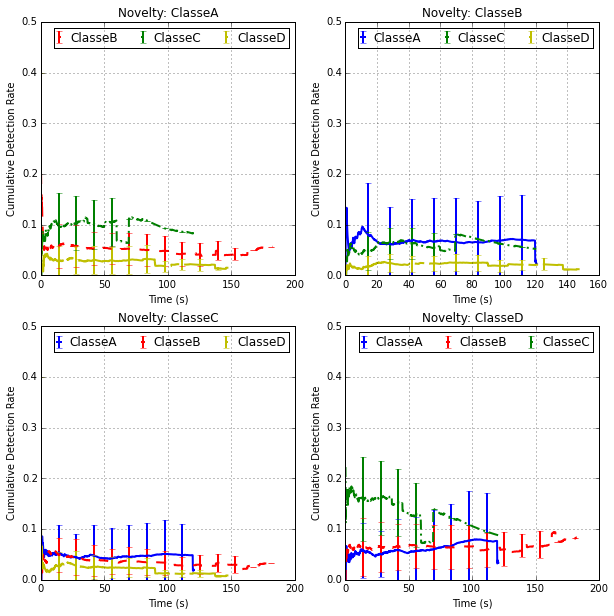

In [10]:
plt.figure(figsize=(10,10), facecolor='w')
for ifig, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2, ifig+1)
    for cls, rundata in Y[novcls]['KnownAsNov'].items():
        maxT = np.max([globaldata[cls][irun]['Signal'].shape[1] for irun in globaldata[cls].keys()])
        eff_y = np.zeros((len(globaldata[cls]), maxT)) * np.nan # runs x time total
        eff_x = np.zeros((len(globaldata[cls]), maxT)) * np.nan
        for irun, run in enumerate(rundata.keys()):
            tpr = rundata[run]
            eff_y[irun, :len(tpr)] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
            eff_x[irun, :len(tpr)] = Y[novcls]['Timew'][cls][run]
        # Plot
        icls = np.nonzero(classes == cls)[0][0]
        avgeff = np.nanmean(eff_y, axis=0)
        stdeff = np.nanstd(eff_y, axis=0)
        timew = np.nanmean(eff_x, axis=0)
        plt.errorbar(timew,  avgeff, stdeff,errorevery=100,
                     dashes=dashes[icls],color=colors[icls],label=cls)
    # Plot labels
    plt.ylim([0.,0.5])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Detection Rate')
    plt.title('Novelty: ' + novcls)
    plt.legend(loc='best', ncol=3, handlelength=0.3,borderpad=0.3)
        

#### Cumulative efficiency of detecting a known class as novelty (20s windows)

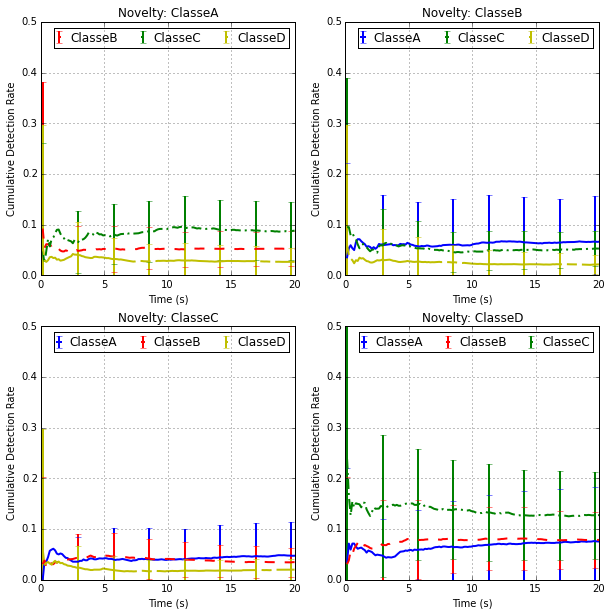

In [82]:
tot_t = 20 # seconds
plt.figure(figsize=(10,10), facecolor='w')
for ifig, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2, ifig+1)
    for cls, rundata in Y[novcls]['KnownAsNov'].items():
        # Sample rate is always the same
        tot_samples = int(tot_t / Y[novcls]['Timew'][cls][0][0])
        N = np.sum([int(Y[novcls]['Timew'][cls][run][-1] / tot_t) for run in rundata.keys()])
        window_eff = np.zeros((N, tot_samples))
        timew = np.linspace(Y[novcls]['Timew'][cls][0][0], tot_t, tot_samples)  
        win_run_idx = 0
        n = 0
        for run in rundata.keys():
            tot_n = int(Y[novcls]['Timew'][cls][run][-1] / tot_t)
            n = n + tot_n
            for iwin in range(tot_n):
                tpr = rundata[run][iwin * tot_samples : (iwin+1)*tot_samples]
                window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
                win_run_idx = win_run_idx + 1
        # Plot
        icls = np.nonzero(classes == cls)[0][0]
        plt.errorbar(timew,  np.mean(window_eff, axis=0), np.std(window_eff, axis=0),
                     errorevery=20, dashes=dashes[icls],color=colors[icls],label=cls)
    # Plot labels
    plt.ylim([0.,0.5])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Detection Rate')
    plt.title('Novelty: ' + novcls)
    plt.legend(loc='best', ncol=3, handlelength=0.3,borderpad=0.3)

#### Cumulative Efficiency Of Novelty

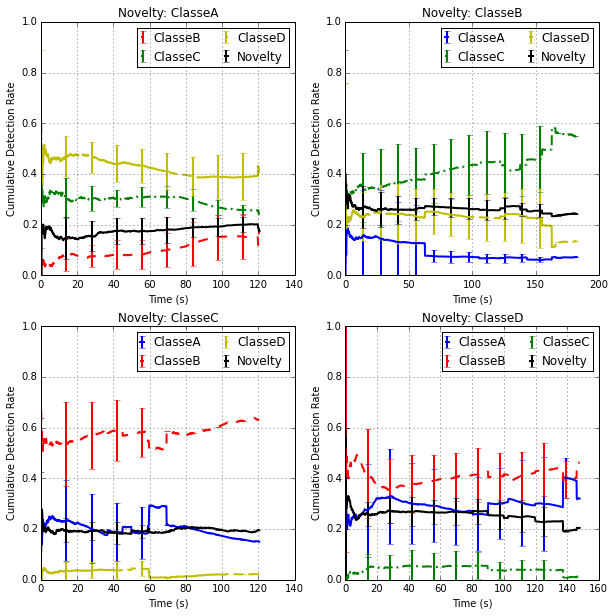

In [11]:
plt.figure(figsize=(10,10),facecolor='w')
for ifig, novcls in enumerate(noveltyclasses):
    tot = 0
    plt.subplot(2,2, ifig+1)
    # Known classes
    maxT = np.max([globaldata[novcls][irun]['Signal'].shape[1] for irun in globaldata[novcls].keys()])
    eff_y = np.zeros((len(globaldata[novcls]), maxT)) * np.nan # runs x time total
    eff_x = np.zeros((len(globaldata[novcls]), maxT)) * np.nan
    for cls, rundata in Y[novcls]['NovelAsKnown'].items():
        for irun, run in enumerate(rundata.keys()):
            tpr = Y[novcls]['NovelAsKnown'][cls][run]
            eff_y[irun, :len(tpr)] = np.cumsum(tpr) / np.arange(1, len(tpr)+1, dtype='f')
            eff_x[irun, :len(tpr)] = Y[novcls]['Timew'][novcls][run]
        # Plot
        icls = np.nonzero(classes == cls)[0][0]
        avgeff = np.nanmean(eff_y, axis=0)
        stdeff = np.nanstd(eff_y, axis=0)
        timew = np.nanmean(eff_x, axis=0)
        plt.errorbar(timew,  avgeff, stdeff,errorevery=100,
                     dashes=dashes[icls],color=colors[icls],label=cls)
    # Novelty itself  
    maxT = np.max([globaldata[novcls][irun]['Signal'].shape[1] for irun in globaldata[novcls].keys()])
    eff_y = np.zeros((len(globaldata[novcls]), maxT)) * np.nan # runs x time total
    eff_x = np.zeros((len(globaldata[novcls]), maxT)) * np.nan
    for irun, run in enumerate(globaldata[novcls].keys()):
        tpr = Y[novcls]['NovelDet'][run]
        eff_y[irun, :len(tpr)] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
        eff_x[irun, :len(tpr)] = Y[novcls]['Timew'][novcls][run]
    # Plot
    avgeff = np.nanmean(eff_y, axis=0)
    stdeff = np.nanstd(eff_y, axis=0)
    timew = np.nanmean(eff_x, axis=0)
    plt.errorbar(timew,  avgeff, stdeff,errorevery=100,color='k',label='Novelty')
    # Plot labels
    plt.ylim([0.,1])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Detection Rate')
    plt.title('Novelty: ' + novcls)
    plt.legend(loc='best', ncol=2, handlelength=0.3,borderpad=0.3)
        

#### Cumulative Efficiency Of Novelty (20s window)

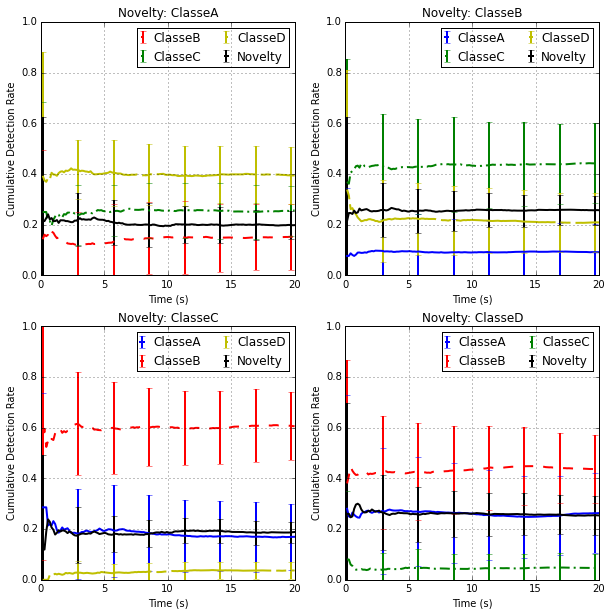

In [89]:
tot_t = 20 # seconds
plt.figure(figsize=(10,10), facecolor='w')
for ifig, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2, ifig+1)
    for cls, rundata in Y[novcls]['NovelAsKnown'].items():
        # Sample rate is always the same
        tot_samples = int(tot_t / Y[novcls]['Timew'][novcls][0][0])
        N = np.sum([int(Y[novcls]['Timew'][novcls][run][-1] / tot_t) for run in rundata.keys()])
        window_eff = np.zeros((N, tot_samples))
        timew = np.linspace(Y[novcls]['Timew'][novcls][0][0], tot_t, tot_samples)  
        win_run_idx = 0
        for run in rundata.keys():
            tot_n = int(Y[novcls]['Timew'][novcls][run][-1] / tot_t)
            for iwin in range(tot_n):
                tpr = Y[novcls]['NovelAsKnown'][cls][run][iwin * tot_samples : (iwin+1)*tot_samples]
                window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
                win_run_idx = win_run_idx + 1
        # Plot
        icls = np.nonzero(classes == cls)[0][0]
        plt.errorbar(timew,  np.mean(window_eff, axis=0), np.std(window_eff, axis=0),
                     errorevery=20, dashes=dashes[icls],color=colors[icls],label=cls)
    # Novelty itself  
    tot_samples = int(tot_t / Y[novcls]['Timew'][novcls][0][0])
    N = np.sum([int(Y[novcls]['Timew'][novcls][run][-1] / tot_t) for run in globaldata[novcls].keys()])
    window_eff = np.zeros((N, tot_samples))
    timew = np.linspace(Y[novcls]['Timew'][novcls][0][0], tot_t, tot_samples)  
    win_run_idx = 0
    for irun, run in enumerate(globaldata[novcls].keys()):
        tot_n = int(Y[novcls]['Timew'][novcls][run][-1] / tot_t)
        for iwin in range(tot_n):
            tpr = Y[novcls]['NovelDet'][run][iwin * tot_samples : (iwin+1)*tot_samples]
            window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
            win_run_idx = win_run_idx + 1
    # Plot
    plt.errorbar(timew,  np.mean(window_eff, axis=0), np.std(window_eff, axis=0),
                 errorevery=20, fmt='k-',label='Novelty')
    # Plot labels
    plt.ylim([0.,1])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Detection Rate')
    plt.title('Novelty: ' + novcls)
    plt.legend(loc='best', ncol=2, handlelength=0.3,borderpad=0.3)